In [1]:
from __future__ import print_function, division
import torch
import torch
import torch.nn as nn
import torch.optim as optim
import data as dt
import model_1 as md
import copy
from pytorch_ssim import ssim
from torch.utils.data import DataLoader

In [2]:
# print gpu
torch.cuda.set_device(5)
currentDevice = torch.cuda.current_device()
print("Current GPU: " + str(currentDevice))
print(str(torch.cuda.device_count()))
print(str(torch.cuda.get_device_capability(currentDevice)))
print(torch.__version__)

Current GPU: 5
8
(6, 1)
1.0.0


In [3]:
USE_GPU = 1
if USE_GPU and torch.cuda.is_available():
    device = torch.device('cuda:5')
else:
    device = "cpu"
print(device)

cuda:5


In [ ]:
# generate csv file, run only for the first time
# dt.generate_csv()

In [4]:
csvFilePath = dt.get_csv_path()
transformed_dataset = dt.HE_SHG_Dataset(csv_file=csvFilePath,
                                               transform=dt.Compose([                                              
                                               dt.Rescale(96),
                                               dt.Normalize(),
                                               dt.ToTensor() 
                                           ]))
# TODO: change the normalization parameters

In [5]:
# batchsize 32->16
dataloader = DataLoader(transformed_dataset, batch_size=50,
                        shuffle=True, num_workers=0)

0 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
1 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
2 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
3 torch.Size([50, 3, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


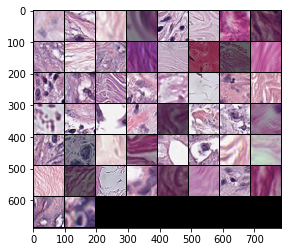

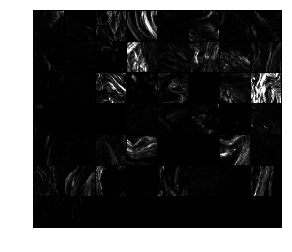

In [6]:
# TODO: insert back mean and variance to plot the image appropriately
dt.show_patch(dataloader) 

In [7]:
print('===> Building model')
model = md.Net().to(device)
criterionMSE = nn.MSELoss()

optimizer = optim.Adam(model.parameters(), lr=0.001)


===> Building model


In [8]:
def train(epoch):
    epoch_loss = 0
    for iteration, batch in enumerate(dataloader):
        input, target = batch['input'].to(device), batch['output'].to(device)

        optimizer.zero_grad()
        output = model(input)
        targetf = target.float()
        targetf = targetf[:, None]
        
        lossMSE = criterionMSE(output, targetf)      
        lossSSIM = -(ssim(output, targetf)-1)
        
        p = 0.75
        loss = p*lossMSE + (1-p)*lossSSIM
        combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
        
        epoch_loss = epoch_loss + combineLoss
        loss.backward()
        optimizer.step()
    
        if iteration%50 == 0:
            print("lossMSE: " + str(lossMSE.item()) +
                  " " + "lossSSIM: " + str(lossSSIM.item()))
            print("===> Epoch[{}]({}/{}): Loss: {:.4f}".format(epoch, iteration, len(dataloader), loss.item()))

    print("===> Epoch {} Complete: Avg. Loss: {:.4f}".format(epoch, epoch_loss / len(dataloader)))


In [ ]:
# def test():
#     avg_psnr = 0
#     with torch.no_grad():
#         for batch in testing_data_loader:
#             input, target = batch[0].to(device), batch[1].to(device)

#             prediction = model(input)
#             mse = criterion(prediction, target)
#             psnr = 10 * log10(1 / mse.item())
#             avg_psnr += psnr
#     print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(testing_data_loader)))


In [ ]:
# def checkpoint(epoch):
#     model_out_path = "model_epoch_{}.pth".format(epoch)
#     torch.save(model, model_out_path)
#     print("Checkpoint saved to {}".format(model_out_path))

In [9]:
for epoch in range(1, 10 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.7425975203514099 lossSSIM: 1.0014628171920776
===> Epoch[1](0/16220): Loss: 0.8073
lossMSE: 0.6282332539558411 lossSSIM: 0.9973931312561035
===> Epoch[1](50/16220): Loss: 0.7205
lossMSE: 0.5838706493377686 lossSSIM: 0.9718345403671265
===> Epoch[1](100/16220): Loss: 0.6809
lossMSE: 0.5057194828987122 lossSSIM: 0.8573595285415649
===> Epoch[1](150/16220): Loss: 0.5936
lossMSE: 0.4553243815898895 lossSSIM: 0.9472048878669739
===> Epoch[1](200/16220): Loss: 0.5783
lossMSE: 0.3903668224811554 lossSSIM: 1.040162444114685
===> Epoch[1](250/16220): Loss: 0.5528
lossMSE: 0.33078789710998535 lossSSIM: 0.7383902072906494
===> Epoch[1](300/16220): Loss: 0.4327
lossMSE: 0.30030471086502075 lossSSIM: 0.8032944202423096
===> Epoch[1](350/16220): Loss: 0.4261
lossMSE: 0.25784164667129517 lossSSIM: 0.5089032053947449
===> Epoch[1](400/16220): Loss: 0.3206
lossMSE: 0.22573626041412354 lossSSIM: 0.5315463542938232
===> Epoch[1](450/16220): Loss: 0.3022
lossMSE: 0.18090522289276123 lossSSIM: 0

lossMSE: 0.006335497368127108 lossSSIM: 0.3378314971923828
===> Epoch[1](4200/16220): Loss: 0.0892
lossMSE: 0.011210517957806587 lossSSIM: 0.29424411058425903
===> Epoch[1](4250/16220): Loss: 0.0820
lossMSE: 0.00935292150825262 lossSSIM: 0.3145774006843567
===> Epoch[1](4300/16220): Loss: 0.0857
lossMSE: 0.011027718894183636 lossSSIM: 0.35697323083877563
===> Epoch[1](4350/16220): Loss: 0.0975
lossMSE: 0.010455372743308544 lossSSIM: 0.3615807890892029
===> Epoch[1](4400/16220): Loss: 0.0982
lossMSE: 0.00833699107170105 lossSSIM: 0.3334624767303467
===> Epoch[1](4450/16220): Loss: 0.0896
lossMSE: 0.006440209224820137 lossSSIM: 0.29409152269363403
===> Epoch[1](4500/16220): Loss: 0.0784
lossMSE: 0.006720535457134247 lossSSIM: 0.30811089277267456
===> Epoch[1](4550/16220): Loss: 0.0821
lossMSE: 0.005899065174162388 lossSSIM: 0.31734055280685425
===> Epoch[1](4600/16220): Loss: 0.0838
lossMSE: 0.0021646793466061354 lossSSIM: 0.24057328701019287
===> Epoch[1](4650/16220): Loss: 0.0618
lossM

KeyboardInterrupt: 

In [10]:
import matplotlib.pyplot as plt
from torchvision import transforms, utils
def test():
    avg_psnr = 0
    with torch.no_grad():
        for iteration, batch in enumerate(dataloader):
            input, target = batch['input'].to(device), batch['output'].to(device)
                
            prediction = model(input)

            target = target.float()

            outdataloader = {'input':prediction,'output':target}
            
            print(outdataloader['input'].size(), 
                      outdataloader['output'].size())

            plt.figure()
            input_batch, label_batch = outdataloader['input'], outdataloader['output']
            batch_size = 50
            im_size = input_batch.size(2)
            label_batch=label_batch.reshape([batch_size,1,im_size,im_size])
            print(label_batch.size())
#             for img in input_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)
                            
#             for img in label_batch:
#                 for t, m, s in zip(img, [0.5, 0.5, 0.5], [0.5, 0.5, 0.5]):
#                     t.mul_(s).add_(m)                           

            grid = utils.make_grid(input_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))
            plt.figure()

            grid = utils.make_grid(label_batch).cpu()
            plt.imshow(grid.numpy().transpose((1, 2, 0)))

            plt.axis('off')
            plt.ioff()
            plt.show()
            
            targetf = target[:, None]
            
            lossMSE = criterionMSE(prediction, targetf)      
            lossSSIM = -ssim(prediction, targetf)
        
            p = 0.75
            loss = p*lossMSE + (1-p)*lossSSIM
            combineLoss = p*lossMSE.item() + (1-p)*lossSSIM.item()
#             mse = criterion(prediction, target.float())

            psnr = 10 * torch.log10(1 / loss)
            avg_psnr += psnr
            if iteration == 16:
                break
    print("===> Avg. PSNR: {:.4f} dB".format(avg_psnr / len(dataloader)))

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


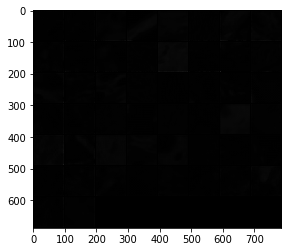

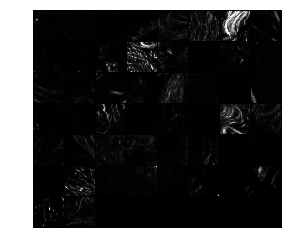

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


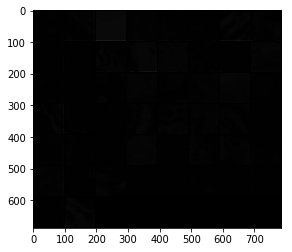

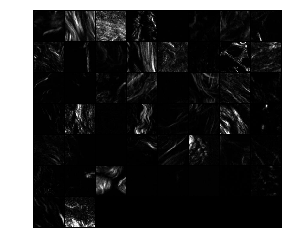

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


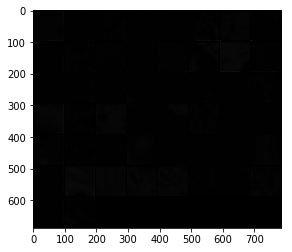

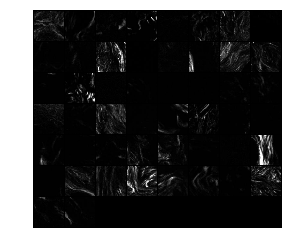

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


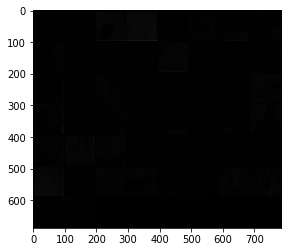

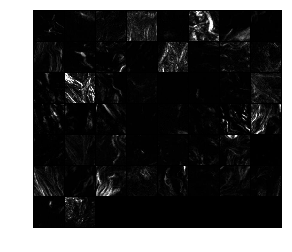

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


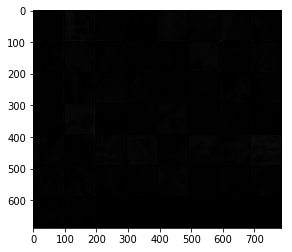

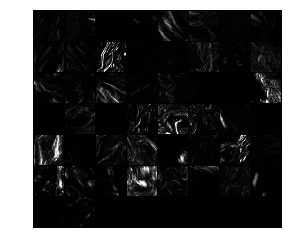

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


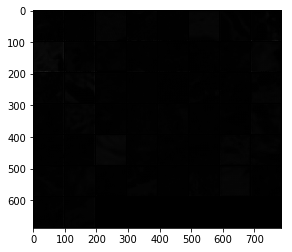

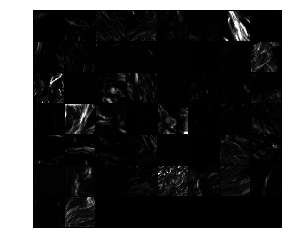

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


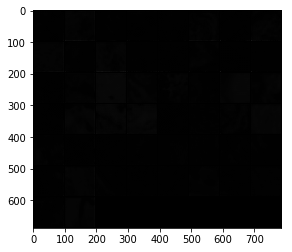

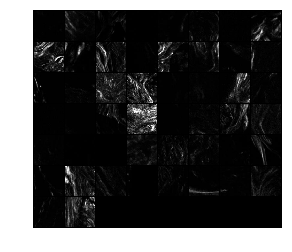

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


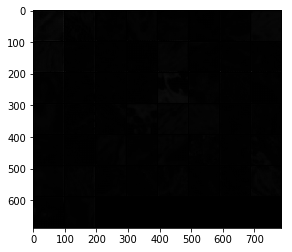

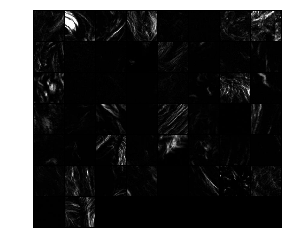

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


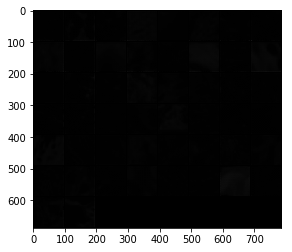

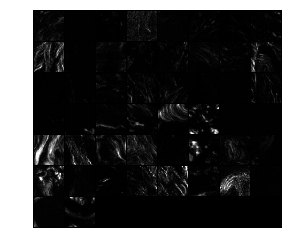

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


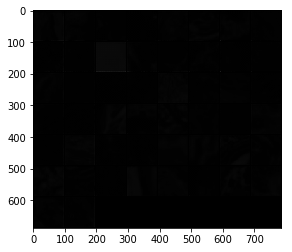

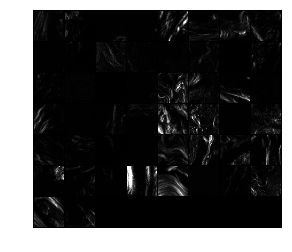

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


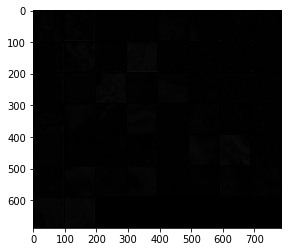

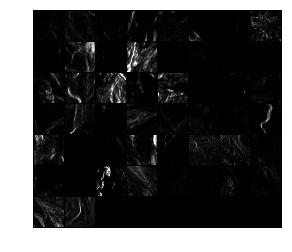

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


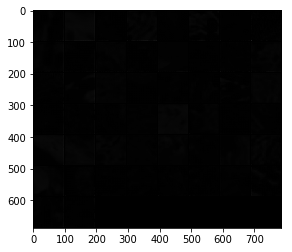

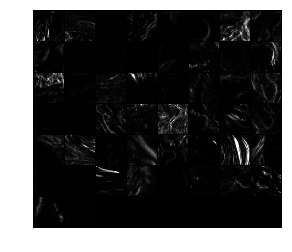

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


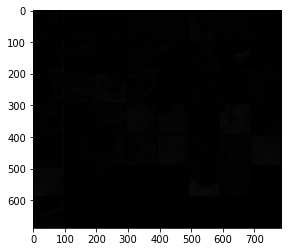

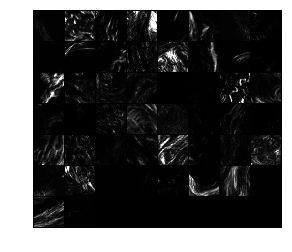

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


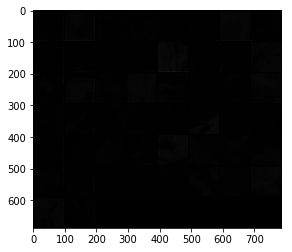

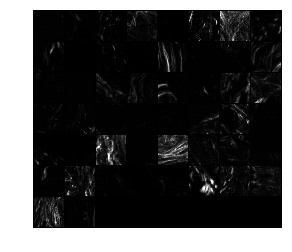

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


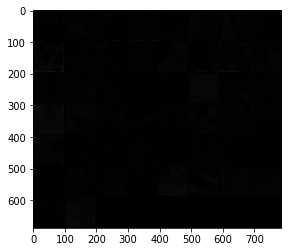

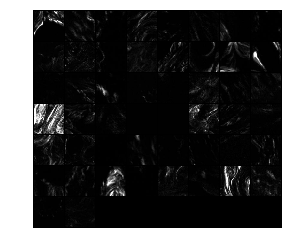

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


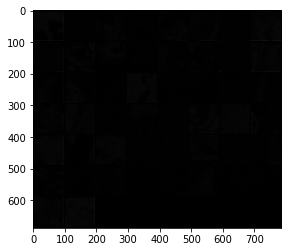

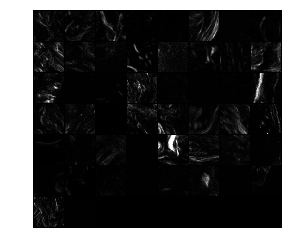

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


torch.Size([50, 1, 96, 96]) torch.Size([50, 96, 96])
torch.Size([50, 1, 96, 96])


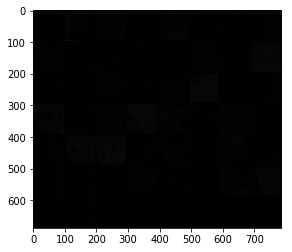

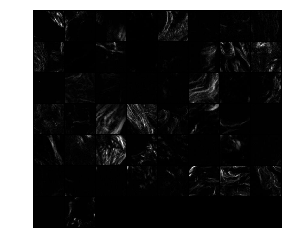

===> Avg. PSNR: nan dB


In [11]:
test()

In [ ]:
# restart
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)

lossMSE: 0.009475882165133953 lossSSIM: 0.32830125093460083
===> Epoch[1](0/16220): Loss: 0.0892
lossMSE: 0.008420519530773163 lossSSIM: 0.3082771301269531
===> Epoch[1](50/16220): Loss: 0.0834
lossMSE: 0.009414227679371834 lossSSIM: 0.3351069688796997
===> Epoch[1](100/16220): Loss: 0.0908
lossMSE: 0.004293682519346476 lossSSIM: 0.3306487202644348
===> Epoch[1](150/16220): Loss: 0.0859
lossMSE: 0.004298878833651543 lossSSIM: 0.2821734547615051
===> Epoch[1](200/16220): Loss: 0.0738
lossMSE: 0.005793393589556217 lossSSIM: 0.29795509576797485
===> Epoch[1](250/16220): Loss: 0.0788
lossMSE: 0.005019638687372208 lossSSIM: 0.28132307529449463
===> Epoch[1](300/16220): Loss: 0.0741
lossMSE: 0.007035865914076567 lossSSIM: 0.369925856590271
===> Epoch[1](350/16220): Loss: 0.0978
lossMSE: 0.010537762194871902 lossSSIM: 0.3477041721343994
===> Epoch[1](400/16220): Loss: 0.0948
lossMSE: 0.009400252252817154 lossSSIM: 0.35364866256713867
===> Epoch[1](450/16220): Loss: 0.0955
lossMSE: 0.008418764

lossMSE: 0.008742132224142551 lossSSIM: 0.29980117082595825
===> Epoch[1](4150/16220): Loss: 0.0815
lossMSE: 0.006779255345463753 lossSSIM: 0.3060746192932129
===> Epoch[1](4200/16220): Loss: 0.0816
lossMSE: 0.0052340286783874035 lossSSIM: 0.2772065997123718
===> Epoch[1](4250/16220): Loss: 0.0732
lossMSE: 0.01569310761988163 lossSSIM: 0.32033950090408325
===> Epoch[1](4300/16220): Loss: 0.0919
lossMSE: 0.006626720540225506 lossSSIM: 0.2684391736984253
===> Epoch[1](4350/16220): Loss: 0.0721
lossMSE: 0.005791311152279377 lossSSIM: 0.30574488639831543
===> Epoch[1](4400/16220): Loss: 0.0808
lossMSE: 0.005351257510483265 lossSSIM: 0.26121145486831665
===> Epoch[1](4450/16220): Loss: 0.0693
lossMSE: 0.005957035347819328 lossSSIM: 0.26582086086273193
===> Epoch[1](4500/16220): Loss: 0.0709
lossMSE: 0.010139795951545238 lossSSIM: 0.35447150468826294
===> Epoch[1](4550/16220): Loss: 0.0962
lossMSE: 0.006288563366979361 lossSSIM: 0.3029544949531555
===> Epoch[1](4600/16220): Loss: 0.0805
loss

lossMSE: 0.006929589435458183 lossSSIM: 0.2705391049385071
===> Epoch[1](8300/16220): Loss: 0.0728
lossMSE: 0.007438052445650101 lossSSIM: 0.27499717473983765
===> Epoch[1](8350/16220): Loss: 0.0743
lossMSE: 0.007331271190196276 lossSSIM: 0.3230664134025574
===> Epoch[1](8400/16220): Loss: 0.0863
lossMSE: 0.004218756221234798 lossSSIM: 0.27942508459091187
===> Epoch[1](8450/16220): Loss: 0.0730
lossMSE: 0.00467256736010313 lossSSIM: 0.2856423854827881
===> Epoch[1](8500/16220): Loss: 0.0749
lossMSE: 0.01169669535011053 lossSSIM: 0.2724202275276184
===> Epoch[1](8550/16220): Loss: 0.0769
lossMSE: 0.006459110416471958 lossSSIM: 0.30648231506347656
===> Epoch[1](8600/16220): Loss: 0.0815
lossMSE: 0.01353578083217144 lossSSIM: 0.3309292793273926
===> Epoch[1](8650/16220): Loss: 0.0929
lossMSE: 0.01142011396586895 lossSSIM: 0.33463484048843384
===> Epoch[1](8700/16220): Loss: 0.0922
lossMSE: 0.002423558384180069 lossSSIM: 0.21188122034072876
===> Epoch[1](8750/16220): Loss: 0.0548
lossMSE: 

lossMSE: 0.006841236725449562 lossSSIM: 0.30503904819488525
===> Epoch[1](12450/16220): Loss: 0.0814
lossMSE: 0.004677707329392433 lossSSIM: 0.24162280559539795
===> Epoch[1](12500/16220): Loss: 0.0639
lossMSE: 0.002347345929592848 lossSSIM: 0.22605425119400024
===> Epoch[1](12550/16220): Loss: 0.0583
lossMSE: 0.009514092467725277 lossSSIM: 0.31937193870544434
===> Epoch[1](12600/16220): Loss: 0.0870
lossMSE: 0.007707375567406416 lossSSIM: 0.2810526490211487
===> Epoch[1](12650/16220): Loss: 0.0760
lossMSE: 0.006908963900059462 lossSSIM: 0.30093133449554443
===> Epoch[1](12700/16220): Loss: 0.0804
lossMSE: 0.015166967175900936 lossSSIM: 0.35264354944229126
===> Epoch[1](12750/16220): Loss: 0.0995
lossMSE: 0.010823637247085571 lossSSIM: 0.3272629380226135
===> Epoch[1](12800/16220): Loss: 0.0899
lossMSE: 0.0045801433734595776 lossSSIM: 0.2658007740974426
===> Epoch[1](12850/16220): Loss: 0.0699
lossMSE: 0.007231515366584063 lossSSIM: 0.31869280338287354
===> Epoch[1](12900/16220): Loss:

lossMSE: 0.006469275802373886 lossSSIM: 0.2951841950416565
===> Epoch[2](300/16220): Loss: 0.0786
lossMSE: 0.007162562571465969 lossSSIM: 0.3345869183540344
===> Epoch[2](350/16220): Loss: 0.0890
lossMSE: 0.007705147843807936 lossSSIM: 0.2727540135383606
===> Epoch[2](400/16220): Loss: 0.0740
lossMSE: 0.009997257962822914 lossSSIM: 0.27739471197128296
===> Epoch[2](450/16220): Loss: 0.0768
lossMSE: 0.005747346673160791 lossSSIM: 0.31575286388397217
===> Epoch[2](500/16220): Loss: 0.0832
lossMSE: 0.006560864858329296 lossSSIM: 0.32132208347320557
===> Epoch[2](550/16220): Loss: 0.0853
lossMSE: 0.012430105358362198 lossSSIM: 0.3443613052368164
===> Epoch[2](600/16220): Loss: 0.0954
lossMSE: 0.00329746026545763 lossSSIM: 0.27084046602249146
===> Epoch[2](650/16220): Loss: 0.0702
lossMSE: 0.009309133514761925 lossSSIM: 0.29933035373687744
===> Epoch[2](700/16220): Loss: 0.0818
lossMSE: 0.007237000856548548 lossSSIM: 0.32615506649017334
===> Epoch[2](750/16220): Loss: 0.0870
lossMSE: 0.0108

lossMSE: 0.00451406417414546 lossSSIM: 0.3151639699935913
===> Epoch[2](4450/16220): Loss: 0.0822
lossMSE: 0.00950508750975132 lossSSIM: 0.3492283225059509
===> Epoch[2](4500/16220): Loss: 0.0944
lossMSE: 0.006038266699761152 lossSSIM: 0.30660760402679443
===> Epoch[2](4550/16220): Loss: 0.0812
lossMSE: 0.006479581817984581 lossSSIM: 0.28845953941345215
===> Epoch[2](4600/16220): Loss: 0.0770
lossMSE: 0.012402310036122799 lossSSIM: 0.3656775951385498
===> Epoch[2](4650/16220): Loss: 0.1007
lossMSE: 0.006342331413179636 lossSSIM: 0.2843552231788635
===> Epoch[2](4700/16220): Loss: 0.0758
lossMSE: 0.008641057647764683 lossSSIM: 0.2699742913246155
===> Epoch[2](4750/16220): Loss: 0.0740
lossMSE: 0.0032046239357441664 lossSSIM: 0.25665736198425293
===> Epoch[2](4800/16220): Loss: 0.0666
lossMSE: 0.00455129612237215 lossSSIM: 0.2603136897087097
===> Epoch[2](4850/16220): Loss: 0.0685
lossMSE: 0.006775136571377516 lossSSIM: 0.2942938208580017
===> Epoch[2](4900/16220): Loss: 0.0787
lossMSE: 

lossMSE: 0.006366631016135216 lossSSIM: 0.34156179428100586
===> Epoch[2](8600/16220): Loss: 0.0902
lossMSE: 0.004560665227472782 lossSSIM: 0.30877232551574707
===> Epoch[2](8650/16220): Loss: 0.0806
lossMSE: 0.009823920205235481 lossSSIM: 0.3213692307472229
===> Epoch[2](8700/16220): Loss: 0.0877
lossMSE: 0.011030529625713825 lossSSIM: 0.30893903970718384
===> Epoch[2](8750/16220): Loss: 0.0855
lossMSE: 0.0086906049400568 lossSSIM: 0.3021305799484253
===> Epoch[2](8800/16220): Loss: 0.0821
lossMSE: 0.006924013141542673 lossSSIM: 0.3301677703857422
===> Epoch[2](8850/16220): Loss: 0.0877
lossMSE: 0.004241593647748232 lossSSIM: 0.24488741159439087
===> Epoch[2](8900/16220): Loss: 0.0644
lossMSE: 0.005618254654109478 lossSSIM: 0.3143247961997986
===> Epoch[2](8950/16220): Loss: 0.0828
lossMSE: 0.006626782473176718 lossSSIM: 0.2999085783958435
===> Epoch[2](9000/16220): Loss: 0.0799
lossMSE: 0.00708804652094841 lossSSIM: 0.3142377734184265
===> Epoch[2](9050/16220): Loss: 0.0839
lossMSE: 

lossMSE: 0.010313930921256542 lossSSIM: 0.29995137453079224
===> Epoch[2](12700/16220): Loss: 0.0827
lossMSE: 0.004271065350621939 lossSSIM: 0.2949807047843933
===> Epoch[2](12750/16220): Loss: 0.0769
lossMSE: 0.007017455995082855 lossSSIM: 0.2861698865890503
===> Epoch[2](12800/16220): Loss: 0.0768
lossMSE: 0.007738324347883463 lossSSIM: 0.29789334535598755
===> Epoch[2](12850/16220): Loss: 0.0803
lossMSE: 0.004894531797617674 lossSSIM: 0.29909324645996094
===> Epoch[2](12900/16220): Loss: 0.0784
lossMSE: 0.004210455808788538 lossSSIM: 0.28860026597976685
===> Epoch[2](12950/16220): Loss: 0.0753
lossMSE: 0.004679962992668152 lossSSIM: 0.2912948727607727
===> Epoch[2](13000/16220): Loss: 0.0763
lossMSE: 0.005139180924743414 lossSSIM: 0.30696648359298706
===> Epoch[2](13050/16220): Loss: 0.0806
lossMSE: 0.006299199070781469 lossSSIM: 0.25567948818206787
===> Epoch[2](13100/16220): Loss: 0.0686
lossMSE: 0.007103278301656246 lossSSIM: 0.31185978651046753
===> Epoch[2](13150/16220): Loss: 

lossMSE: 0.0071381558664143085 lossSSIM: 0.2960870862007141
===> Epoch[3](550/16220): Loss: 0.0794
lossMSE: 0.0047310153022408485 lossSSIM: 0.3172442317008972
===> Epoch[3](600/16220): Loss: 0.0829
lossMSE: 0.011556815356016159 lossSSIM: 0.33868032693862915
===> Epoch[3](650/16220): Loss: 0.0933
lossMSE: 0.0047170002944767475 lossSSIM: 0.2749694585800171
===> Epoch[3](700/16220): Loss: 0.0723
lossMSE: 0.010164574719965458 lossSSIM: 0.3656124472618103
===> Epoch[3](750/16220): Loss: 0.0990
lossMSE: 0.011514279991388321 lossSSIM: 0.36960864067077637
===> Epoch[3](800/16220): Loss: 0.1010
lossMSE: 0.018459467217326164 lossSSIM: 0.3459351062774658
===> Epoch[3](850/16220): Loss: 0.1003
lossMSE: 0.008575214073061943 lossSSIM: 0.2839362621307373
===> Epoch[3](900/16220): Loss: 0.0774
lossMSE: 0.009857474826276302 lossSSIM: 0.3156266212463379
===> Epoch[3](950/16220): Loss: 0.0863
lossMSE: 0.004249372519552708 lossSSIM: 0.3167222738265991
===> Epoch[3](1000/16220): Loss: 0.0824
lossMSE: 0.014

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)

In [12]:
optimizer = optim.Adam(model.parameters(), lr=0.00001)

In [ ]:
for epoch in range(1, 10 + 1):
    train(epoch)

In [ ]:
test()

In [ ]:
optimizer = optim.Adam(model.parameters(), lr=0.0001)

In [ ]:
for epoch in range(1, 5 + 1):
    train(epoch)
#     test()
#     checkpoint(epoch)